In [1]:
import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,concatenate, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, ZeroPadding2D, LeakyReLU, ReLU, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time

# 1. Create Train/Val/Test Sets

In [2]:
X = np.load("../dataset/X_v2.npy")
objlist = np.load("../dataset/objlist_v2.npy")
dnnx = np.load("../dataset/dnnx_v2.npy")
y = np.load("../dataset/y_v2.npy",allow_pickle=True)
y, label_strings = pd.factorize(y,sort=True)
y = to_categorical(y)
print(label_strings)

['GALAXY' 'QSO' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

In [4]:
X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [5]:
dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

In [6]:
del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

In [7]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [8]:
def plot_model_change(history,fname="output/time.pdf"):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'],label="Training Acc")
    plt.plot(history.history['val_accuracy'],label="Val Acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],label="Training Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(fname)
    plt.show()

# 2. Train a DNN Classifier

In [9]:
model = Sequential()

model.add(Dense(1024, activation="sigmoid", input_dim=dnnx_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(256, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(32, activation="sigmoid"))
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=0, patience=100, restore_best_weights=True)
cb = [es]
history = model.fit(dnnx_train, y_train,
                    batch_size=2048,
                    epochs = 4000,
                    validation_data = (dnnx_val,y_val),
                    callbacks = cb,
                    verbose = 2)

Epoch 1/4000
59/59 - 0s - loss: 1.1273 - accuracy: 0.3338 - val_loss: 1.0983 - val_accuracy: 0.3304
Epoch 2/4000
59/59 - 0s - loss: 1.0934 - accuracy: 0.3709 - val_loss: 1.0190 - val_accuracy: 0.5427
Epoch 3/4000
59/59 - 0s - loss: 0.9150 - accuracy: 0.5541 - val_loss: 0.7858 - val_accuracy: 0.6217
Epoch 4/4000
59/59 - 0s - loss: 0.7400 - accuracy: 0.6636 - val_loss: 0.6421 - val_accuracy: 0.7159
Epoch 5/4000
59/59 - 0s - loss: 0.6506 - accuracy: 0.7123 - val_loss: 0.5862 - val_accuracy: 0.7365
Epoch 6/4000
59/59 - 0s - loss: 0.6135 - accuracy: 0.7253 - val_loss: 0.5666 - val_accuracy: 0.7469
Epoch 7/4000
59/59 - 0s - loss: 0.5969 - accuracy: 0.7309 - val_loss: 0.5560 - val_accuracy: 0.7509
Epoch 8/4000
59/59 - 0s - loss: 0.5889 - accuracy: 0.7351 - val_loss: 0.5561 - val_accuracy: 0.7413
Epoch 9/4000
59/59 - 0s - loss: 0.5791 - accuracy: 0.7405 - val_loss: 0.5495 - val_accuracy: 0.7560
Epoch 10/4000
59/59 - 0s - loss: 0.5695 - accuracy: 0.7473 - val_loss: 0.5349 - val_accuracy: 0.7659

In [10]:
model.save("output/DNNClassifier.h5")

In [11]:
plot_model(model,"output/DNNMod.pdf",show_shapes=True)

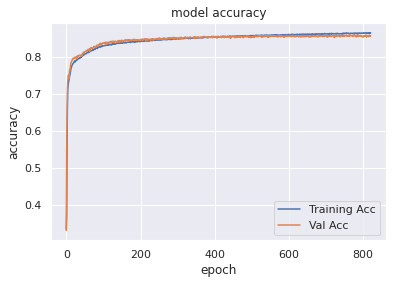

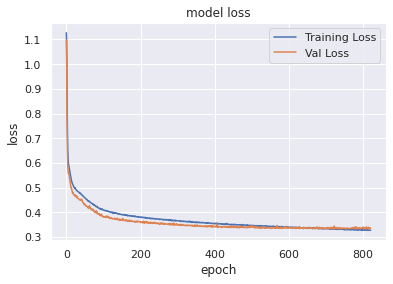

In [12]:
plot_model_change(history,fname="output/DNNTraining.pdf")

In [13]:
preds_test = model.predict(dnnx_test,batch_size=2048, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 12904 correct labels out of 15000 labels
Accuracy: 0.8602666666666666
Precision: 0.8614757534876221
Recall: 0.8609086511621088
F1 Score: 0.8609863716778957
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[4589  242   79]
 [ 164 4227  668]
 [ 159  784 4088]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4910
           1       0.80      0.84      0.82      5059
           2       0.85      0.81      0.83      5031

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

(array([    0,     2,     3, ..., 14996, 14997, 14998]), 0.8602666666666666, 0.8614757534876221, 0.8609086511621088, array([[4589,  242,   79],
       [ 164, 4227,  668],
       [ 159,  784, 4088]]), '              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93      4910\n     

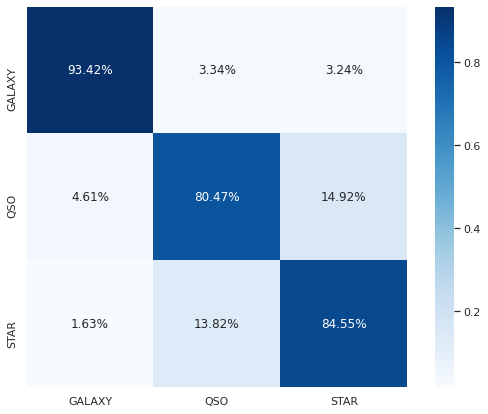

In [14]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/dnn_cm.pdf")

In [15]:
del(dnnx_train)

# 3. Train a CNN Classifier

In [16]:
inp_layer = tf.keras.Input(shape=X_train.shape[1:])

mod = Conv2D(filters=64, kernel_size=(5,5), padding='same')(inp_layer)
mod = ReLU()(mod)


# mod = AveragePooling2D(pool_size=(2, 2), strides=2)(mod)

c1 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c1 = ReLU()(c1)
c2 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c2 = ReLU()(c2)
c3 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c3 = ReLU()(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(c1)
c4 = ReLU()(c4)
c5 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(c1)
c5 = ReLU()(c5)
c6 = Conv2D(filters=64, kernel_size=(5,5), padding='same')(c2)
c6 = ReLU()(c6)
p1 = AveragePooling2D(pool_size=(1, 1))(c3)
mod = concatenate([c4,c5,c6,p1])

c7 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c7 = ReLU()(c7)
c8 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c8 = ReLU()(c8)
c9 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c9 = ReLU()(c9)
c10 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(c7)
c10 = ReLU()(c10)
c11 = Conv2D(filters=92, kernel_size=(3,3), padding='same')(c7)
c11 = ReLU()(c11)
c12 = Conv2D(filters=92, kernel_size=(5,5), padding='same')(c8)
c12 = ReLU()(c12)
p2 = AveragePooling2D(pool_size=(1, 1))(c9)
mod = concatenate([c10,c11,c12,p2])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c13 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c13 = ReLU()(c13)
c14 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c14 = ReLU()(c14)
c15 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c15 = ReLU()(c15)
c16 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c13)
c16 = ReLU()(c16)
c17 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c13)
c17 = ReLU()(c17)
c18 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c14)
c18 = ReLU()(c18)
p3 = AveragePooling2D(pool_size=(1, 1))(c15)
mod = concatenate([c16,c17,c18,p3])

c19 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c19 = ReLU()(c19)
c20 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c20 = ReLU()(c20)
c21 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c21 = ReLU()(c21)
c22 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c19)
c22 = ReLU()(c22)
c23 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c19)
c23 = ReLU()(c23)
c24 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c20)
c24 = ReLU()(c24)
p4 = AveragePooling2D(pool_size=(1, 1))(c21)
mod = concatenate([c22,c23,c24,p4])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c25 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c25 = ReLU()(c25)
c26 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c26 = ReLU()(c26)
c27 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(mod)
c27 = ReLU()(c27)
c28 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c25)
c28 = ReLU()(c28)
p5 = AveragePooling2D(pool_size=(1, 1))(c26)
mod = concatenate([c27,c28,p5])
mod = Flatten()(mod)    #Check
mod = Dense(1024)(mod)
mod = Dense(1024)(mod)
out_layer = Dense(3, activation="softmax") (mod)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])


In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
datagen.fit(X_train)


es = EarlyStopping(monitor='val_loss', verbose=1, patience=30, restore_best_weights=True)

cb = [es]


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (119996, 32, 32, 5) (5 channels).
  ' channels).')


In [18]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=512),
                              epochs = 300, validation_data = (X_val,y_val),
                              callbacks = cb,
                              verbose = 1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (119996, 32, 32, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/300
235/235 [==============================] - 113s 483ms/step - loss: 0.7554 - accuracy: 0.6408 - val_loss: 0.5744 - val_accuracy: 0.7470
Epoch 2/300
235/235 [==============================] - 115s 490ms/step - loss: 0.5091 - accuracy: 0.7869 - val_loss: 0.4952 - val_accuracy: 0.7843
Epoch 3/300
235/235 [==============================] - 113s 481ms/step - loss: 0.4698 - accuracy: 0.8026 - val_loss: 0.4493 - val_accuracy: 0.8072
Epoch 4/300
235/235 [==============================] - 115s 489ms/step - loss: 0.4453 - accuracy: 0.8127 - val_loss: 0.4334 - val_accuracy: 0.8163
Epoch 5/300
235/235 [==============================] - 117s 496ms/step - loss: 0.4358 - accuracy: 0.8159 - val_loss: 0.4508 - val_accuracy: 0.8027
Epoch 6/300
235/235 [==============================] - 113s 480ms/step - loss: 0.4335 - accuracy: 0.8170 - val_loss: 0.4175 - val_accuracy: 0.8203
Epoch 7/300
235/235 [==============================] - 115s 488ms/step - loss: 0.4217 - accuracy: 0.8223 - val_loss: 0

In [19]:
model.save("output/CNNClassifier.h5")

In [20]:
plot_model(model,"output/CNNMod.pdf",show_shapes=True)

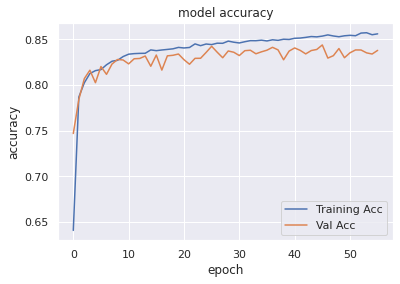

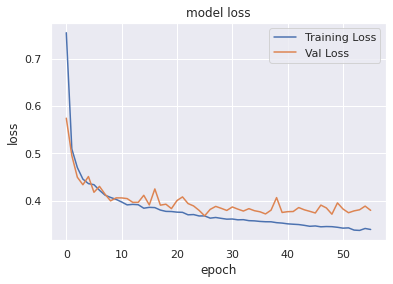

In [21]:
plot_model_change(history,fname="output/CNNTraining.pdf")

In [22]:
preds_test = model.predict(X_test,batch_size=1024, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 12628 correct labels out of 15000 labels
Accuracy: 0.8418666666666667
Precision: 0.8445984383376429
Recall: 0.8423235073475634
F1 Score: 0.8432184316408614
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[4390  309  211]
 [ 179 4155  725]
 [ 142  806 4083]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      4910
           1       0.79      0.82      0.80      5059
           2       0.81      0.81      0.81      5031

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

(array([    0,     2,     3, ..., 14997, 14998, 14999]), 0.8418666666666667, 0.8445984383376429, 0.8423235073475634, array([[4390,  309,  211],
       [ 179, 4155,  725],
       [ 142,  806, 4083]]), '              precision    recall  f1-score   support\n\n           0       0.93      0.89      0.91      4910\n     

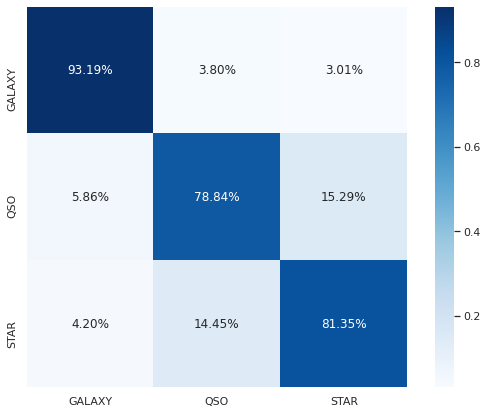

In [23]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/cnn_cm.pdf")

In [24]:
del(X_train)

# 4. Train the Ensemble Classifier

In [25]:
cnnclassifier = load_model("output/CNNClassifier.h5")
dnnclassifier = load_model("output/DNNClassifier.h5")

In [26]:
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = tf.keras.Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
# define ensemble model
members = [cnnclassifier,dnnclassifier]
model = define_stacked_model(members)

In [28]:
filepath="output/EnsembleClassifier.h5"

checkpointcb = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,monitor='loss',mode='min',save_best_only=True,verbose=1,save_weights_only=False)
cb = [checkpointcb]


In [29]:
history = model.fit([X_val, dnnx_val],
                            y_val, epochs=100,
                            batch_size=512,
                            callbacks=cb,
                            verbose=1)

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 1.2451 - accuracy: 0.3328
Epoch 00001: loss improved from inf to 1.24512, saving model to EnsembleClassifier.h5
30/30 [==============================] - 3s 115ms/step - loss: 1.2451 - accuracy: 0.3328
Epoch 2/100
29/30 [============================>.] - ETA: 0s - loss: 1.0844 - accuracy: 0.3338
Epoch 00002: loss improved from 1.24512 to 1.08324, saving model to EnsembleClassifier.h5
30/30 [==============================] - 3s 110ms/step - loss: 1.0832 - accuracy: 0.3344
Epoch 3/100
29/30 [============================>.] - ETA: 0s - loss: 0.9484 - accuracy: 0.4423
Epoch 00003: loss improved from 1.08324 to 0.94813, saving model to EnsembleClassifier.h5
30/30 [==============================] - 3s 110ms/step - loss: 0.9481 - accuracy: 0.4437
Epoch 4/100
29/30 [============================>.] - ETA: 0s - loss: 0.8357 - accuracy: 0.6391
Epoch 00004: loss improved from 0.94813 to 0.83514, saving model to EnsembleClassifier.

In [30]:
del(X_val, dnnx_val)

In [31]:
model = load_model("./EnsembleClassifier.h5")

In [32]:
model.evaluate([X_test, dnnx_test],y_test)

469/469 [==============================] - 5s 10ms/step - loss: 0.3330 - accuracy: 0.8667


[0.33301296830177307, 0.8667333126068115]

In [33]:
plot_model(model,"EnsembleMod.pdf",show_shapes=True)

In [34]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 13000 correct labels out of 15000 labels
Accuracy: 0.8666666666666667
Precision: 0.8681515934920555
Recall: 0.8672795529995055
F1 Score: 0.8676777143228849
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[4585  205  120]
 [ 144 4181  734]
 [  92  705 4234]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      4910
           1       0.82      0.83      0.82      5059
           2       0.83      0.84      0.84      5031

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

(array([    0,     2,     3, ..., 14997, 14998, 14999]), 0.8666666666666667, 0.8681515934920555, 0.8672795529995055, array([[4585,  205,  120],
       [ 144, 4181,  734],
       [  92,  705, 4234]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.93      0.94      4910\n     

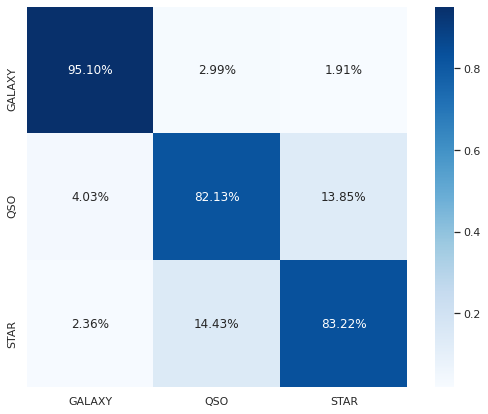

In [35]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/ensemble_cm.pdf")

# 5. Result Analysis

In [36]:
X = np.load("../dataset/X_v2.npy")
objlist = np.load("../dataset/objlist_v2.npy")
dnnx = np.load("../dataset/dnnx_v2.npy")
y = np.load("../dataset/y_v2.npy",allow_pickle=True)
y, label_strings = pd.factorize(y,sort=True)
y = to_categorical(y)
print(label_strings)


zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.1,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1111111, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)


del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

['GALAXY' 'QSO' 'STAR']


In [37]:
model = load_model("output/EnsembleClassifier.h5")

In [38]:
preds_train = model.predict([X_train, dnnx_train],batch_size=512, verbose = 0)
print(get_metrics(preds_train.argmax(axis=1), y_train.argmax(axis=1),label_strings))

Identified 105588 correct labels out of 119996 labels
Accuracy: 0.8799293309776992
Precision: 0.8805448812837087
Recall: 0.8798393944109103
F1 Score: 0.8801475629524941
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[37648  1609   877]
 [ 1104 33686  5202]
 [  599  5017 34254]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     40134
           1       0.84      0.84      0.84     39992
           2       0.85      0.86      0.85     39870

    accuracy                           0.88    119996
   macro avg       0.88      0.88      0.88    119996
weighted avg       0.88      0.88      0.88    119996

(array([     0,      1,      2, ..., 119992, 119993, 119994]), 0.8799293309776992, 0.8805448812837087, 0.8798393944109103, array([[37648,  1609,   877],
       [ 1104, 33686,  5202],
       [  599,  5017, 34254]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.94 

In [39]:
del(dnnx_train,X_train)

In [40]:
preds_val = model.predict([X_val, dnnx_val],batch_size=512, verbose = 0)
print(get_metrics(preds_val.argmax(axis=1), y_val.argmax(axis=1),label_strings))

Identified 13013 correct labels out of 15000 labels
Accuracy: 0.8675333333333334
Precision: 0.8684243797548872
Recall: 0.867693003579935
F1 Score: 0.868024213033212
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[4611  218  127]
 [ 161 4080  708]
 [ 100  673 4322]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      4956
           1       0.82      0.82      0.82      4949
           2       0.84      0.85      0.84      5095

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

(array([    0,     1,     4, ..., 14997, 14998, 14999]), 0.8675333333333334, 0.8684243797548872, 0.867693003579935, array([[4611,  218,  127],
       [ 161, 4080,  708],
       [ 100,  673, 4322]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.93      0.94      4956\n        

In [41]:
del(X_val, dnnx_val)

In [42]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 13000 correct labels out of 15000 labels
Accuracy: 0.8666666666666667
Precision: 0.8681515934920555
Recall: 0.8672795529995055
F1 Score: 0.8676777143228849
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[4585  205  120]
 [ 144 4181  734]
 [  92  705 4234]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      4910
           1       0.82      0.83      0.82      5059
           2       0.83      0.84      0.84      5031

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

(array([    0,     2,     3, ..., 14997, 14998, 14999]), 0.8666666666666667, 0.8681515934920555, 0.8672795529995055, array([[4585,  205,  120],
       [ 144, 4181,  734],
       [  92,  705, 4234]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.93      0.94      4910\n     

In [43]:
df = pd.read_csv("../dataset/paperDF_v2.csv",index_col=0)

In [44]:
df.loc[objlist_train, ["set"]] = "TRAIN"
df.loc[objlist_val, ["set"]] = "VALIDATION"
df.loc[objlist_test, ["set"]] = "TEST"

In [45]:
df.loc[objlist_train, ["pred_class"]] = label_strings[preds_train.argmax(axis=1)]
df.loc[objlist_val, ["pred_class"]] = label_strings[preds_val.argmax(axis=1)]
df.loc[objlist_test, ["pred_class"]] = label_strings[preds_test.argmax(axis=1)]

In [46]:
pgal_train = preds_train[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_train = preds_train[:,np.where(label_strings=="STAR")[0][0]]
pqso_train = preds_train[:,np.where(label_strings=="QSO")[0][0]]

pgal_val = preds_val[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_val = preds_val[:,np.where(label_strings=="STAR")[0][0]]
pqso_val = preds_val[:,np.where(label_strings=="QSO")[0][0]]

pgal_test = preds_test[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_test = preds_test[:,np.where(label_strings=="STAR")[0][0]]
pqso_test = preds_test[:,np.where(label_strings=="QSO")[0][0]]

In [47]:
df.loc[objlist_train, ["prob_gal"]] = pgal_train
df.loc[objlist_train, ["prob_star"]] = pstar_train
df.loc[objlist_train, ["prob_qso"]] = pqso_train

df.loc[objlist_val, ["prob_gal"]] = pgal_val
df.loc[objlist_val, ["prob_star"]] = pstar_val
df.loc[objlist_val, ["prob_qso"]] = pqso_val

df.loc[objlist_test, ["prob_gal"]] = pgal_test
df.loc[objlist_test, ["prob_star"]] = pstar_test
df.loc[objlist_test, ["prob_qso"]] = pqso_test

In [48]:
df.to_csv("output/iucaa_paper_results_v2.csv")

# 6. Some Plots

In [49]:
sns.set_palette("tab10")

In [50]:
df = pd.read_csv("output/iucaa_paper_results_v2.csv")

In [51]:
subdflist = []

bin_size = 0.1
lower_bin_list = np.arange(20,23,bin_size)
bad_lower_bin=[]
acclist = []
f1list = []
reportlist = []
num_samplelist = []
starmaglist = []
galmaglist = []
qsomaglist = []

for lower_bin in lower_bin_list:
#     print(f"******************** {lower_bin} < r <= {lower_bin+bin_size} ********************")
    subdf = df[(
        ((df["dered_r"]+df["extinction_r"]) > lower_bin) & 
        ((df["dered_r"]+df["extinction_r"]) <= lower_bin+bin_size)
    )]
    # Choose equal number of stars, galaxies and qsos
    min_num = subdf["class"].value_counts().min()
    if min_num < 50:
        bad_lower_bin.append(lower_bin)
        continue
    s1 = subdf[subdf["class"]=="GALAXY"].sample(n=min_num)
    galmaglist.append((s1["dered_r"]+s1["extinction_r"]).to_numpy())
    s2 = subdf[subdf["class"]=="STAR"].sample(n=min_num)
    starmaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    s3 = subdf[subdf["class"]=="QSO"].sample(n=min_num)
    qsomaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    num_samplelist.append(min_num)
    subdf = pd.concat([s1,s2,s3])
    subdflist.append(subdf)
    
    accuracy = metrics.accuracy_score(subdf["class"], subdf["pred_class"])
    f1score = metrics.f1_score(subdf["class"], subdf["pred_class"],average='macro')
    report = metrics.classification_report(subdf["class"], subdf["pred_class"],output_dict=True)
    reportlist.append(report)
    acclist.append(accuracy)
    f1list.append(f1score)

bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

galmaglist = np.concatenate(galmaglist)

starmaglist = np.concatenate(starmaglist)

qsomaglist = np.concatenate(qsomaglist)

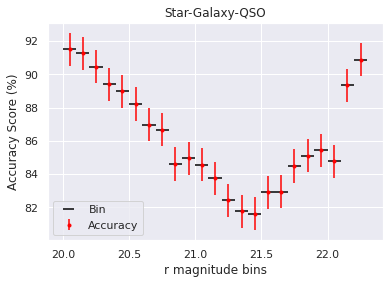

In [52]:
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, xerr=bin_size/2, fmt=" ",color="black",label="Bin")
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, yerr=0.01*100,fmt=".",color="red",label="Accuracy")
# plt.errorbar(lower_bin_list+bin_size/2, f1list, yerr=0.01,label="F1 Score")
plt.legend()
plt.title("Star-Galaxy-QSO")
plt.xlabel("r magnitude bins")
plt.ylabel("Accuracy Score (%)")
plt.savefig("output/V2_FAINT_SGQ.pdf")

In [53]:
subdfs = pd.concat(subdflist)
subdfs["r"]=subdfs["dered_r"]+subdfs["extinction_r"]

In [54]:
gal_recall_list = []
gal_precision_list = []
star_recall_list = []
star_precision_list = []
qso_precision_list = []
qso_recall_list = []
for r in reportlist:
    gal_recall_list.append(r["GALAXY"]["recall"])
    gal_precision_list.append(r["GALAXY"]["precision"])
    star_recall_list.append(r["STAR"]["recall"])
    star_precision_list.append(r["STAR"]["precision"])
    qso_recall_list.append(r["QSO"]["recall"])
    qso_precision_list.append(r["QSO"]["precision"])

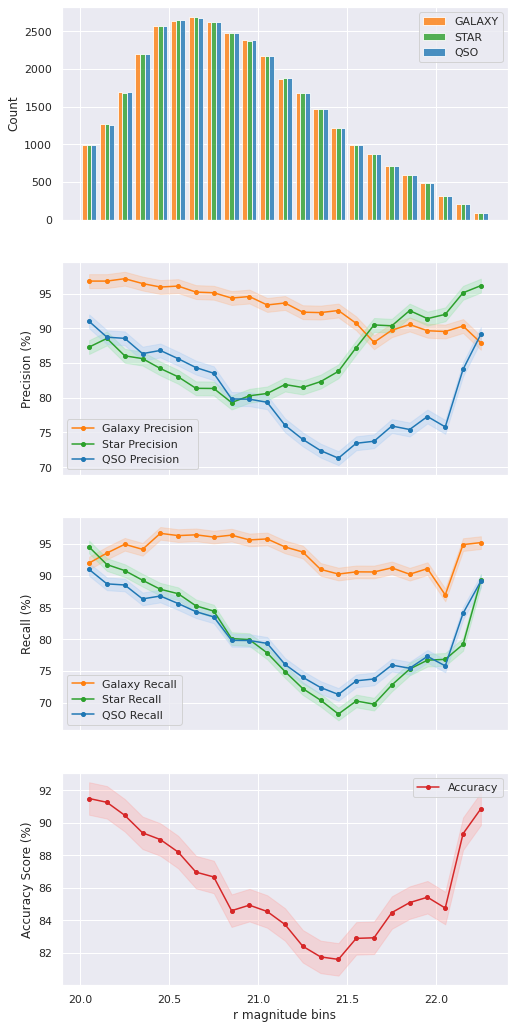

In [55]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,sharex=True, figsize=(8,18))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
qsocolor = sns.color_palette("tab10")[0]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2


d1 = subdfs[subdfs["class"]=="GALAXY"]["r"]
d2 = subdfs[subdfs["class"]=="STAR"]["r"]
d3 = subdfs[subdfs["class"]=="QSO"]["r"]

ax1.hist([d1, d2, d3], color=[galcolor,starcolor, qsocolor],
         alpha=0.8, label=["GALAXY","STAR","QSO"],bins=len(lower_bin_list))
ax1.set_ylabel("Count")

ax1.legend()


y_ax1 = np.array(gal_precision_list)
y_ax2 = np.array(star_precision_list)
y_ax3 = np.array(qso_precision_list)

ax2.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Precision",color=galcolor)
ax2.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax2.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Precision",color=starcolor)
ax2.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
                 color=sns.color_palette("pastel")[2], alpha=0.3)
ax2.errorbar(x_ax, y_ax3*100,fmt="-o", ms=4, label="QSO Precision",color=qsocolor)
ax2.fill_between(x_ax, y_ax3*100 - dyfit*100, y_ax3*100 + dyfit*100,
                 color=sns.color_palette("pastel")[0], alpha=0.3)
ax2.set_ylabel("Precision (%)")
ax2.legend()



y_ax1 = np.array(gal_recall_list)
y_ax2 = np.array(star_recall_list)
y_ax3 = np.array(qso_precision_list)

ax3.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Recall",color=galcolor)
ax3.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax3.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Recall",color=starcolor)
ax3.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
             color=sns.color_palette("pastel")[2], alpha=0.3)
ax3.errorbar(x_ax, y_ax3*100,fmt="-o", ms=4, label="QSO Recall",color=qsocolor)
ax3.fill_between(x_ax, y_ax3*100 - dyfit*100, y_ax3*100 + dyfit*100,
             color=sns.color_palette("pastel")[0], alpha=0.3)
ax3.set_ylabel("Recall (%)")
ax3.legend()



y_ax1 = np.array(acclist)
y_ax2 = np.array(f1list)
ax4.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Accuracy",color=acccolor)
# ax4.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="F1 Score",color=f1color)
ax4.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[3], alpha=0.3)
ax4.set_ylabel("Accuracy Score (%)")
ax4.legend()

plt.xlabel("r magnitude bins")


# plt.suptitle("Star-Galaxy-QSO")
plt.savefig("output/Star_Galaxy_QSO_v2Set.pdf")
plt.show()